In [73]:
# import qsharp

# import networkx as nx
# import numpy as np

In [88]:
# qsharp.init(project_root='./')


# f = qsharp.run("testing.SayHelloQ([1,5],3)",shots=1)

Q# initialized with configuration: {'targetProfile': 'unrestricted', 'languageFeatures': []}

# Quantum Approximate Optimization Algorithm using Gate-based QC

This notebook consists of a implementation of multi anlge QAOA (or ma-QAOA) using Pennylane.

In [1]:
# Importing required libraries

# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

# Library for circuit simulation
import pennylane as qml

# Library for Graph creation
import networkx as nx

# Q# Import
import qsharp as q

In [2]:
# Setting Q# root folder path
q.init(project_root='./')

Q# initialized with configuration: {'targetProfile': 'unrestricted', 'languageFeatures': []}

In [3]:
def integer_to_counts(n: int, result: list) -> dict:
    """
    Given a list of integers (output of the circuit), returns a dictionary with the counts of each integer.

    Args:
        n (int): The number of qubits in the circuit. Width of the bitstring.
        a (list): The integer array to be converted.

    Returns:
        dict: A dictionary representing the counts of the integers (bitstrings).

    Example:
        >>> interger_to_counts(2 ,[1, 2, 3, 2, 1, 0])
        {'00': 1, '01': 2, '10': 1, '11': 0}
    """
    counts = {}
    for i in range(2**n):
        counts[np.binary_repr(i,width=n)] = 0
    for integer in result:
        counts[np.binary_repr(integer,width=n)] += 1
    return counts

def arr_to_str(a: np.ndarray) -> str:
    """
    Converts a given array to a string representation.

    Args:
        a (list): The array to be converted.

    Returns:
        str: The string representation of the array.

    Example:
        >>> arr_to_str([1, 2, 3])
        '[1, 2, 3]'
    """
    string =''
    for i in a:
        string += str(i) + ","
    return '[' + string[:-1] + ']'

## Building the model and its Cost Function 
We are using ***docplex*** to build the model and calculate $Q$ and $c$.

In [4]:
# Function to sort the count dictionary.
def find_most_common_solutions(input_dict, n):
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]

# Function to plot the graph
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    # edge_labels = nx.get_edge_attributes(G, "weight")
    return None

# Returns the flat index of the matrix given the row and column indices.
def flat_index(n: int, i: int, j: int) -> int:
    return int(n*i + j)

# Function to print the solution
def print_solution_maxcut(graph: nx.Graph, counts: dict) -> None:
    
    # Printing Solutions Sets.
    best_sol = find_most_common_solutions(counts,3)
    print(f'\n\nTop 3 solutions for the graph {graph} and {layers} layers: \n{best_sol}')

    def plot_solution(G,pos,results):
        c = ["r" if b == "0" else "c" for b in find_most_common_solutions(results, 1)[0]]
        draw_graph(G, c, pos)

    pos = nx.spring_layout(graph)
    plot_solution(graph,pos,counts)

    return None

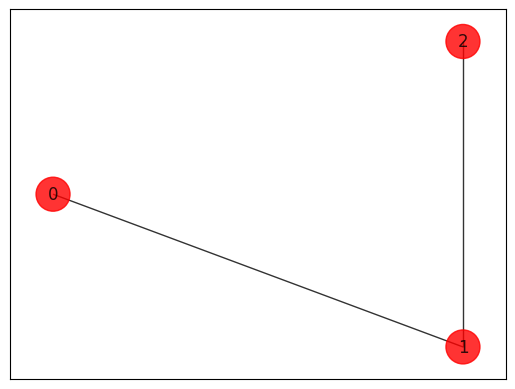

In [5]:
# Initializing a Graph Instance.

# Generating a graph of 3 nodes
# Nodes in the Graph.
n = 3  # Number of nodes in graph
G3 = nx.Graph()
G3.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0)]
G3.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G3.nodes()]
pos_3 = nx.shell_layout(G3)

draw_graph(G3, colors, pos_3)

In [6]:
def build_qubo_maxcut(graph: nx.Graph):

    n_nodes = graph.number_of_nodes()
    edges = graph.edges()
    
    model = Model()

    x = model.binary_var_list(n_nodes)
    Q = -1*sum(graph.get_edge_data(i,j).get('weight')*x[i]*(1-x[j]) for i,j in edges)

    model.minimize(Q)

    problem = from_docplex_mp(model)
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)

    return qubo

## Creating the QAOA circuit and layers.

I'm using ***Pennylane*** to handle the circuit simulations. I have created functions to generate the QAOA circuit given $Q$ and $c$.

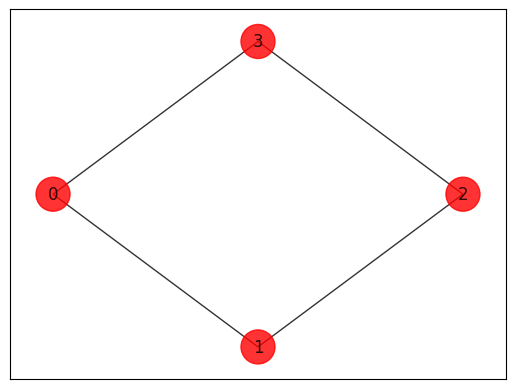

In [7]:
# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 4  # Number of nodes in graph
G4 = nx.Graph()
G4.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (0, 3, 1.0)]
G4.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G4.nodes()]
pos_4 = nx.shell_layout(G4)

draw_graph(G4, colors, pos_4)

In [8]:
# Function to create a dictionary of edge weights with key as the tuple of nodes. 
def edge_weight(graph: nx.Graph):
    edge_dict = {}
    for (i,j) in graph.edges():
        w = graph.edges()[i,j]['weight']
        edge_dict[(i,j)] = w
    return edge_dict

Iteration: 1 - Cost: -0.0
Iteration: 2 - Cost: -0.0
Iteration: 3 - Cost: -0.0
Iteration: 4 - Cost: -0.0
Iteration: 5 - Cost: -0.0
Iteration: 6 - Cost: -0.0
Iteration: 7 - Cost: -0.0
Iteration: 8 - Cost: -0.0
Iteration: 9 - Cost: -0.0
Iteration: 10 - Cost: -0.0
Iteration: 11 - Cost: -0.0
Iteration: 12 - Cost: -0.0
Iteration: 13 - Cost: -0.0
Iteration: 14 - Cost: -0.0
Iteration: 15 - Cost: -0.0
Iteration: 16 - Cost: -0.0
Iteration: 17 - Cost: -0.0
Elapsed time for QAOA: 434.4 seconds
Gammas: [0.62831853 0.62831853 0.62831853 0.62831853 0.62831853 0.62831853
 0.62831853 0.62831853]
Betas: [0.39269908 0.39269908 0.39269908 0.39269908 0.39269908 0.39269908
 0.39269908 0.39269908]
Counts:
{'0000': 151, '0001': 17, '0010': 9, '0011': 23, '0100': 11, '0101': 5, '0110': 29, '0111': 16, '1000': 14, '1001': 21, '1010': 2, '1011': 12, '1100': 19, '1101': 14, '1110': 12, '1111': 145}



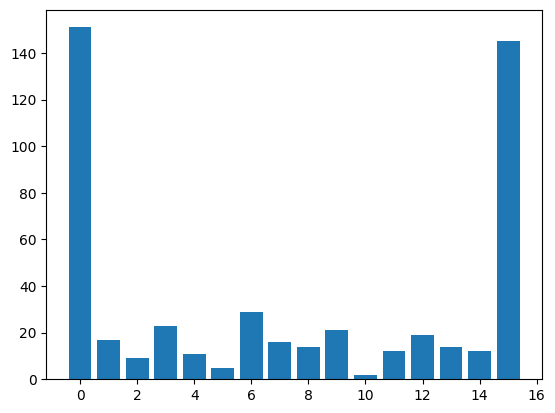

In [12]:
def ma_qaoa_maxcut(graph: nx.Graph,layers:int):

    # Building the QUBO model and graph parameters
    qubo = build_qubo_maxcut(graph)

    num_qubits = graph.number_of_nodes()
    n_edges = graph.number_of_edges()

    edges = []
    weights = []
    for (i,j) in graph.edges():
        edges.append((i*num_qubits+j))
        weights.append(graph.get_edge_data(i,j).get('weight'))


    # Initial guess
    init_gamma = np.array([pi/5]*n_edges*layers)
    init_beta = np.array([pi/8]*num_qubits*layers)
    initial_guess = np.concatenate((init_gamma, init_beta))
    
    def expectation_value(theta:np.ndarray,callback_dict:dict):

        sep = int(n_edges*layers)
        gammas = theta[:sep]
        betas = theta[sep:]

        input_str = f"{num_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(edges)},{arr_to_str(weights)}"

        results = q.run(f"ma_qaoa.ma_circuit({input_str})",shots=500)
        
        counts = integer_to_counts(num_qubits, results)
        best_sol = find_most_common_solutions(counts,1)[0]

        exp = qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))

        callback_dict["iters"] += 1
        callback_dict["prev_vector"].append(theta)
        callback_dict["cost_history"].append(-1*exp)

        print(f'Iteration: {callback_dict["iters"]} - Cost: {callback_dict["cost_history"][-1]}')

        return exp

    callback_dict = {
        "prev_vector": [],
        "iters": 0,
        "cost_history": [],
    }

    # Minimization of the objective function.
    start_time = time.time()

    # # Minimize the cost function using scipy
    res = minimize(
        expectation_value, 
        initial_guess, 
        args=(callback_dict), 
        method="bfgs", # Classical optimizer
        options={'maxiter': 100}) # Maximum number of iterations

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time for QAOA: {round(elapsed_time,2)} seconds')
    
    sep = int(n_edges*layers)
    prime_gammas = res.x[:sep]
    prime_betas = res.x[sep:]

    print(f'Gammas: {prime_gammas}\nBetas: {prime_betas}')

    input_str = f"{num_qubits},{layers},{arr_to_str(prime_gammas)},{arr_to_str(prime_betas)},{arr_to_str(edges)},{arr_to_str(weights)}"

    results = q.run(f"ma_qaoa.ma_circuit({input_str})",shots=500)
    counts = integer_to_counts(num_qubits, results)

    # best_sol = find_most_common_solutions(counts,1)[0]

    return counts, callback_dict


In [ ]:
# Defining the layers
layers = 2

# Running QAOA on for Number Partitioning. 
counts, callback = ma_qaoa_maxcut(G4,layers)

print(f"Counts:\n{counts}\n")

# Potting
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.show()

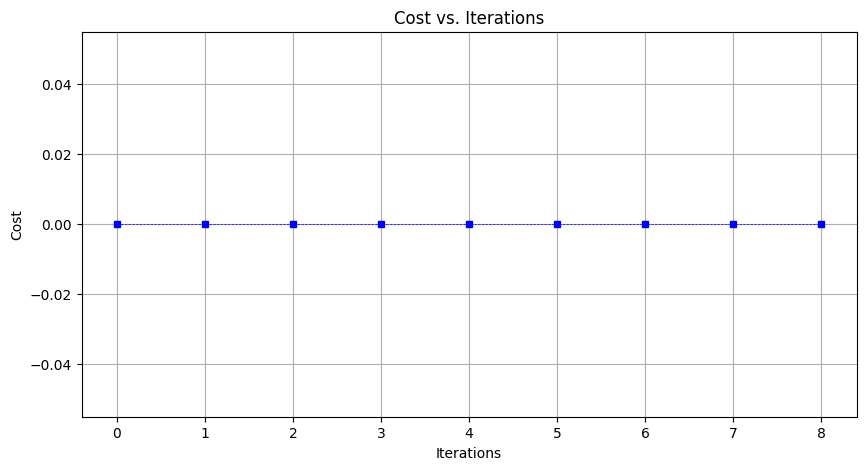

In [10]:
# Plotting cost vs. iterations.
def plot_cost(callback_dict:dict):
    cost = callback_dict["cost_history"]
    iter = list(range(callback_dict["iters"]))
    # Plotting Cost vs. Iterations

    plt.figure(figsize=(10, 5),dpi=100)
    plt.plot(iter,cost,c='blue',ls='--',lw=0.5,marker='s',ms=4)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs. Iterations')
    plt.show()

plot_cost(callback)



Top 3 solutions for the graph Graph with 4 nodes and 4 edges and 1 layers: 
['1111', '0000', '0110']


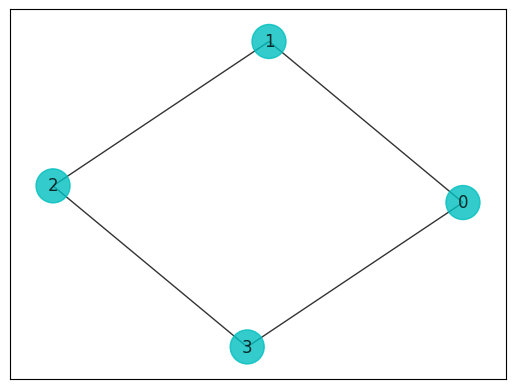

In [11]:
print_solution_maxcut(G4,counts)

In [16]:
def test(graph: nx.Graph,layers:int):
    num_qubits = graph.number_of_nodes()
    n_edges = graph.number_of_edges()

    edges = []
    weights = []
    for (i,j) in graph.edges():
        edges.append((i*num_qubits+j))
        weights.append(graph.get_edge_data(i,j).get('weight'))
    
    gammas = np.array([np.pi/5]*n_edges*layers)
    betas = np.array([np.pi/5]*num_qubits*layers)

    input_str = f"{num_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(edges)},{arr_to_str(weights)}"

    out = q.run(f"ma_qaoa.ma_circuit({input_str})",shots=1000)

    return out

In [17]:
test(G4,2)

[15,
 0,
 0,
 15,
 15,
 15,
 15,
 0,
 15,
 6,
 15,
 0,
 0,
 15,
 0,
 0,
 15,
 15,
 1,
 1,
 15,
 0,
 15,
 15,
 9,
 15,
 0,
 15,
 13,
 0,
 15,
 15,
 0,
 15,
 15,
 15,
 15,
 15,
 0,
 11,
 15,
 0,
 15,
 1,
 0,
 0,
 15,
 8,
 15,
 13,
 7,
 7,
 8,
 0,
 0,
 15,
 2,
 15,
 0,
 2,
 15,
 0,
 0,
 15,
 0,
 0,
 15,
 15,
 0,
 15,
 0,
 0,
 0,
 0,
 15,
 14,
 0,
 0,
 13,
 0,
 15,
 10,
 15,
 0,
 15,
 7,
 15,
 7,
 0,
 15,
 0,
 0,
 15,
 15,
 0,
 15,
 0,
 15,
 0,
 15,
 2,
 8,
 0,
 4,
 0,
 15,
 11,
 1,
 15,
 15,
 0,
 0,
 15,
 0,
 0,
 15,
 11,
 13,
 15,
 13,
 0,
 0,
 3,
 0,
 15,
 0,
 0,
 15,
 15,
 0,
 0,
 15,
 8,
 7,
 15,
 15,
 13,
 13,
 0,
 1,
 2,
 9,
 4,
 4,
 8,
 15,
 0,
 0,
 9,
 11,
 0,
 15,
 0,
 13,
 0,
 0,
 11,
 0,
 11,
 0,
 15,
 0,
 0,
 15,
 15,
 15,
 15,
 0,
 15,
 15,
 15,
 15,
 0,
 0,
 0,
 15,
 4,
 15,
 10,
 2,
 15,
 0,
 15,
 7,
 15,
 0,
 0,
 15,
 0,
 15,
 0,
 13,
 11,
 0,
 15,
 0,
 15,
 15,
 0,
 14,
 0,
 15,
 14,
 11,
 15,
 15,
 2,
 0,
 0,
 0,
 2,
 4,
 0,
 0,
 15,
 15,
 0,
 15,
 0,
 15,
 0,
 0,
 0,
 1

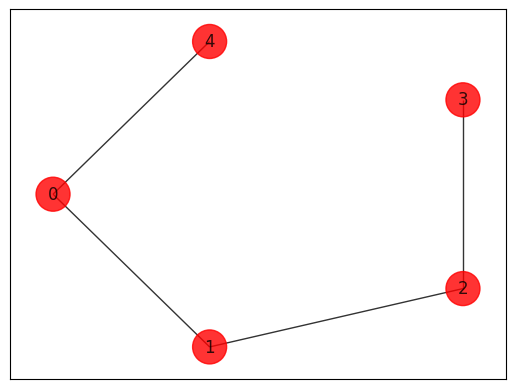

In [19]:
# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 5  # Number of nodes in graph
g = nx.Graph()
g.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (0, 4, 1.0)]
g.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in g.nodes()]
pos_4 = nx.shell_layout(g)

draw_graph(g, colors, pos_4)

In [20]:
test(g,1)

[16,
 17,
 31,
 24,
 17,
 4,
 0,
 20,
 0,
 23,
 19,
 1,
 16,
 17,
 13,
 21,
 14,
 16,
 18,
 13,
 0,
 22,
 28,
 9,
 31,
 0,
 14,
 0,
 4,
 10,
 31,
 19,
 31,
 30,
 17,
 13,
 4,
 26,
 28,
 21,
 21,
 6,
 31,
 20,
 0,
 8,
 23,
 8,
 14,
 14,
 22,
 7,
 18,
 21,
 1,
 0,
 19,
 26,
 21,
 0,
 0,
 27,
 0,
 14,
 0,
 17,
 4,
 23,
 17,
 13,
 27,
 14,
 15,
 12,
 13,
 19,
 14,
 1,
 10,
 28,
 31,
 17,
 12,
 14,
 19,
 0,
 14,
 10,
 15,
 27,
 0,
 13,
 22,
 31,
 18,
 1,
 21,
 19,
 12,
 12,
 28,
 0,
 31,
 28,
 8,
 18,
 4,
 21,
 23,
 20,
 2,
 0,
 31,
 0,
 10,
 15,
 8,
 31,
 17,
 27,
 31,
 17,
 21,
 5,
 19,
 9,
 25,
 25,
 2,
 25,
 27,
 30,
 21,
 27,
 15,
 12,
 19,
 31,
 18,
 0,
 0,
 14,
 23,
 4,
 15,
 22,
 13,
 12,
 30,
 31,
 1,
 19,
 14,
 27,
 7,
 18,
 14,
 10,
 0,
 18,
 31,
 3,
 10,
 1,
 1,
 18,
 2,
 31,
 7,
 11,
 12,
 17,
 0,
 0,
 31,
 17,
 0,
 7,
 5,
 15,
 31,
 10,
 0,
 0,
 14,
 8,
 18,
 30,
 17,
 9,
 14,
 17,
 28,
 7,
 1,
 21,
 10,
 14,
 7,
 14,
 31,
 18,
 0,
 12,
 18,
 13,
 5,
 31,
 0,
 15,
 17,
 0,
 10